In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

# Preparing the dataset

Use only the following columns:

* `'engine_displacement'`,
* `'horsepower'`,
* `'vehicle_weight'`,
* `'model_year'`,
* `'fuel_efficiency_mpg'`

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

In [3]:
df.head(5)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [ ]:
df_part = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']].copy()

In [5]:
df_part.dtypes

engine_displacement      int64
horsepower             float64
vehicle_weight         float64
model_year               int64
fuel_efficiency_mpg    float64
dtype: object

# Exploratory Data Analysis

* Look at the `fuel_efficiency_mpg` variable. Does it have a long tail? 

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

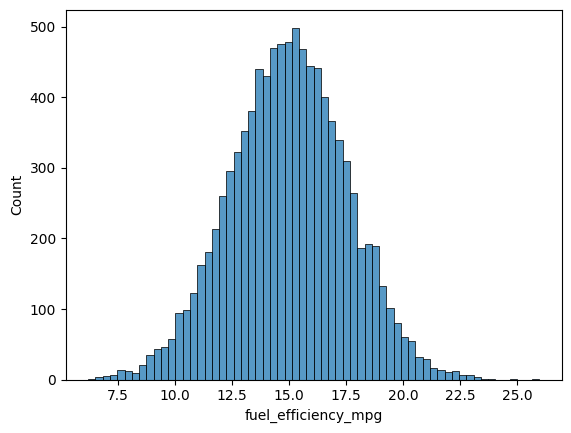

In [6]:
sns.histplot(df_part['fuel_efficiency_mpg'])

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

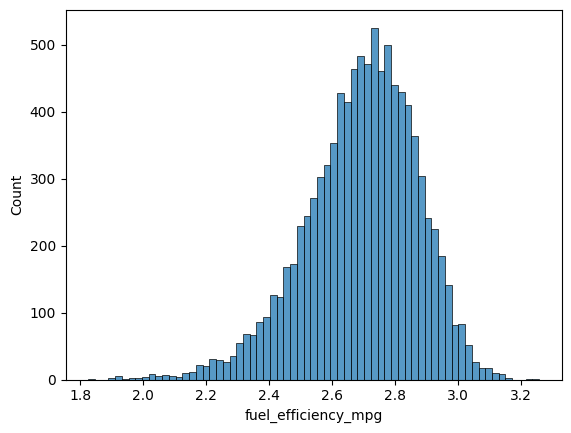

In [7]:
sns.histplot(np.log(df_part['fuel_efficiency_mpg']))  # It does not have a long tail

# Q1

There's one column with missing values. What is it?


In [8]:
df_part.columns[df_part.isnull().any()]

Index(['horsepower'], dtype='object')

# Q2

What's the median (50% percentile) for variable `'horsepower'`?


In [9]:
df_part['horsepower'].median()

np.float64(149.0)

# Split data

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [10]:
n_val = int(0.2*len(df_part))
n_test = int(0.2*len(df_part))
n_train = len(df_part) - n_val - n_test

In [25]:
index = np.arange(len(df_part))

np.random.seed(42)
np.random.shuffle(index)

df_train = df_part.iloc[index[:n_train]].copy()
df_val = df_part.iloc[index[n_train:n_train+n_val]].copy()
df_test = df_part.iloc[index[n_train+n_val:]].copy()

In [22]:
df_train.shape, df_val.shape, df_test.shape

((5824, 5), (1940, 5), (1940, 5))

In [26]:
y_train = df_train['fuel_efficiency_mpg'].to_numpy()
y_val = df_val['fuel_efficiency_mpg'].to_numpy()
y_test = df_test['fuel_efficiency_mpg'].to_numpy()

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [27]:
df_train.head()

,engine_displacement,horsepower,vehicle_weight,model_year
483,220,144.0,2535.887591,2009
7506,160,141.0,2741.170484,2019
8795,230,155.0,2471.880237,2017
1688,150,206.0,3748.164469,2015
6217,300,111.0,2135.716359,2006


# Q3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

## Fill with zero

In [28]:
df_train['horsepower'].isnull().sum(), df_val['horsepower'].isnull().sum(), df_test['horsepower'].isnull().sum()

(np.int64(429), np.int64(136), np.int64(143))

In [29]:
def Linear_regression(X, y, reg=0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T@X + reg*np.eye(X.shape[1])
    w_full = np.linalg.inv(XTX) @ X.T @ y
    
    return w_full[0], w_full[1:]

def RMSE(y, y_pred):
    return np.sqrt( ((y-y_pred)**2).mean())

In [30]:
df_train_zero = df_train.fillna(0)
df_val_zero = df_val.fillna(0)
df_test_zero = df_test.fillna(0)

w0, w = Linear_regression(df_train_zero, y_train)
y_pred = w0 + df_val_zero @ w

RMSE(y_val, y_pred), round(RMSE(y_val, y_pred), 2)

(np.float64(0.5173782638841655), np.float64(0.52))

## Fill with mean

In [31]:
df_train_mean = df_train.fillna(df_train['horsepower'].mean())
df_val_mean = df_val.fillna(df_val['horsepower'].mean())
df_test_mean = df_val.fillna(df_test['horsepower'].mean())

w0, w = Linear_regression(df_train_mean, y_train)
y_pred = w0 + df_val_mean @ w

RMSE(y_val, y_pred), round(RMSE(y_val, y_pred), 2) 

(np.float64(0.4636236995017951), np.float64(0.46))

# Q4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [32]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:

    w0, w = Linear_regression(df_train_zero, y_train, reg=r)
    y_pred = w0 + df_val_zero@ w

    print(f'{r}: {RMSE(y_val, y_pred)}, {round(RMSE(y_val, y_pred), 2)}')

0: 0.5173782638841655, 0.52
0.01: 0.517111552576255, 0.52
0.1: 0.5187525130701096, 0.52
1: 0.5222348802092593, 0.52
5: 0.522891609282353, 0.52
10: 0.5229812979636556, 0.52
100: 0.5230636233819932, 0.52


# Q5

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

In [33]:
rmses = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    index = np.arange(len(df_part))

    np.random.seed(seed)
    np.random.shuffle(index)

    df_train = df_part.iloc[index[:n_train]].copy()
    df_val = df_part.iloc[index[n_train:n_train+n_val]].copy()
    df_test = df_part.iloc[index[n_train+n_val:]].copy()

    y_train = df_train['fuel_efficiency_mpg'].to_numpy()
    y_val = df_val['fuel_efficiency_mpg'].to_numpy()
    y_test = df_test['fuel_efficiency_mpg'].to_numpy()

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    df_train.loc[:, 'horsepower'] = df_train['horsepower'].fillna(0)
    
    w0, w = Linear_regression(df_train, y_train, reg=0.)
    y_pred = w0 + df_val@ w

    print(f'{seed}: {RMSE(y_val, y_pred)}, {round(RMSE(y_val, y_pred), 2)}')
    
    rmses.append(RMSE(y_val, y_pred))


np.std(rmses), round(np.std(rmses), 3)

0: 0.49888899071630294, 0.5
1: 0.501115359859881, 0.5
2: 0.49835205126840526, 0.5
3: 0.489915026583234, 0.49
4: 0.49167000044704956, 0.49
5: 0.497849188871302, 0.5
6: 0.5065072587060622, 0.51
7: 0.49165086292927496, 0.49
8: 0.4843367003139488, 0.48
9: 0.4964111667767962, 0.5


(np.float64(0.006030493111664775), np.float64(0.006))

# Q6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

In [34]:
index = np.arange(len(df_part))

np.random.seed(9)
np.random.shuffle(index)

df_train = df_part.iloc[index[:n_train+n_val]].copy()
df_test = df_part.iloc[index[n_train+n_val:]].copy()

y_train = df_train['fuel_efficiency_mpg'].to_numpy()
y_test = df_test['fuel_efficiency_mpg'].to_numpy()

del df_train['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_train.loc[:, 'horsepower'] = df_train['horsepower'].fillna(0)
df_test.loc[:, 'horsepower'] = df_test['horsepower'].fillna(0)

w0, w = Linear_regression(df_train, y_train, reg=0.001)
y_pred = w0 + df_test@ w

print(f'{seed}: {RMSE(y_test, y_pred)}, {round(RMSE(y_test, y_pred), 4)}')

9: 0.5156261299166541, 0.5156
